##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [9]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pix2Pix

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 15 seconds on a single V100 GPU.

Below is the output generated after training the model for 200 epochs.

![sample output_1](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![sample output_2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## Load utils file

In [10]:
# https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022
import os
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
# print(os.path.abspath('utils.py'))
import utils
help(utils)

Saving utils.py to utils (1).py
Help on module utils:

NAME
    utils

FUNCTIONS
    avg_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the average for that pixel across
        all images in the z-stack.
    
    get_img_at_t(t, img)
    
    get_max_pixel(embryos, data_path)
        Obtains the maximum pixel value across a set of embryos
        embryos: subset of p_embryo... train, val, test
        data_path: path from which to load processed np embryo data
    
    get_z_slice(z, img)
    
    max_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the maximum for that pixel across
        all images in the z-stack.
    
    middle_z(img)
    
    min_across_z(img, normalize=False)
        Returns a new image where each pixel
        intensity is the minimum for that pixel across
        all images in the z-stack.
    
    normalize(img)
        Normalizes pixel values across all images 

## Import TensorFlow and other libraries

In [11]:
import tensorflow as tf
import numpy as np

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [12]:
!pip install -q -U tensorboard

## Mount the dataset

To run this notebook as a reproducible tutorial, replace this Google Drive home path with your respective data folder.

In [13]:
from google.colab import drive   

# mount the google drive to my Colab session
drive.mount('/content/gdrive')
# use the google drive in my Colab session
home_path = '/content/gdrive/Shared drives/Embryo_data'
print(os.listdir(home_path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['mxnet_cnn2d_embryo_58_fine_tune_data_aug_ResNet50_v2_order_random.ipynb', 'Embryo3', 'Embryo12', 'Embryo13', 'Embryo16', 'Embryo19', 'Embryo18', 'Embryo24', 'Embryo39', 'Embryo42', 'Embryo46', 'Embryo47', 'Embryo23', 'Embryo33', 'Embryo25', 'Embryo95', 'Embryo97', 'Embryo96', 'Embryo98', 'Embryo101', 'Embryo99', 'Embryo100', 'Embryo102', 'Embryo76', 'Embryo78', 'Embryo81', 'Embryo79', 'Embryo80', 'Embryo84', 'Embryo85', 'Embryo87', 'Embryo88', 'Embryo92', 'Embryo94', 'Embryo93', 'embryo_info_CS101.xlsx', 'data', 'processed', 'models', 'pix2pix_PyTorch-GAN.ipynb', 'annotation.xlsx', 'Embryo110', 'Embryo109', 'Embryo111', 'Embryo113', 'Embryo112', 'Embryo114', 'Embryo116', 'Embryo115', 'Embryo117', 'Embryo118', 'Embryo119', 'Embryo120', 'Embryo103', 'Embryo104', 'Embryo105', 'Embryo107', 'Embryo106', 'Embryo108', 'pix2pix_output', 'images']


## Acquire an output folder

This is for us to read data from Drive and save output images to Drive. To run this as a tutorial, you will need to mimic our Google Drive directory structure and create a folder named `pix2pix_output/` (to store pix2pix output).

In [14]:
try:
  max_trial = max(int(n) for n in os.listdir(f'{home_path}/pix2pix_output'))
  new_trial = max_trial + 1
except ValueError:
  new_trial = 0
print(f'Creating a new folder for current trial #{new_trial}')
TRIAL_PATH = f'{home_path}/pix2pix_output/{new_trial}'
os.mkdir(TRIAL_PATH)
os.mkdir(f'{TRIAL_PATH}/train')
os.mkdir(f'{TRIAL_PATH}/test')
CLASSIFY_PATH = f'{TRIAL_PATH}/classify'
os.mkdir(CLASSIFY_PATH)
os.mkdir(f'{CLASSIFY_PATH}/0')
os.mkdir(f'{CLASSIFY_PATH}/1')
CHECKPOINT_PATH = f'{TRIAL_PATH}/checkpoints'
os.mkdir(CHECKPOINT_PATH)

import datetime
LOG_DIR=f"{TRIAL_PATH}/logs"
LOG_SUB_DIR=f'{LOG_DIR}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
os.mkdir(LOG_DIR)
os.mkdir(LOG_SUB_DIR)

DATA_PATH = f'{TRIAL_PATH}/data'
os.mkdir(DATA_PATH)
for split_type in ['test','train','val']:
  os.mkdir(f'{DATA_PATH}/{split_type}')
  for data_type in ['bf_data','fluo_data']:
    os.mkdir(f'{DATA_PATH}/{split_type}/{data_type}')

Creating a new folder for current trial #3


## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [15]:
# _URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

# path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
#                                       origin=_URL,
#                                       extract=True)

# PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [16]:
# Fixing the random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Available high quality data
embryo_inds = utils.CLEAN_IDX

# Directory of the processed *.npy files
processed_path = f'{home_path}/processed'
polar_processed_path = f'{processed_path}/polarization'

video_time_info, train_embryos, val_embryos, test_embryos = utils.split_train_test_val(home_path, embryo_inds)

z_agg_mode = "Middle Z"
get_data_path = lambda data_type : f'{processed_path}/{data_type}/middle'
pol_path = f'{processed_path}/polarization'

with open(f"{TRIAL_PATH}/z_agg_mode.txt", "w+") as f:
  f.write(f"The z aggregation mode is {z_agg_mode}")

              t_num  first_anno_pol_time
embryo_index                            
3                21                   12
12              143                   11
13              143                   12
16              143                   30
18              143                   27
19              143                   32
23               40                   18
24               21                   20
25               21                   13
33               21                   15
39               21                   12
42               21                   16
46               21                   19
47               21                   17
76              109                   68
78              109                   75
79              109                   68
80              109                   65
81              109                   95
85              109                  102
87              109                   62
88              109                   75
92              

In [17]:
# Option to skip data preparation (assuming this was run before)
SKIP_LOADING = False

# Repeat normal data loading for bf and fluo images
for data_type in ['fluo_data', 'bf_data']:
    if SKIP_LOADING:
        continue

    data_path = get_data_path(data_type)
    print(f'Loading {data_type} data from {data_path}')

    # Set the subpaths to save each partition of the dataset 
    get_save_path = lambda set_type : f'{DATA_PATH}/{set_type}/{data_type}'
    train_path = get_save_path('train')
    val_path = get_save_path('val')
    test_path = get_save_path('test')
    print(f'Saving to {[train_path, val_path, test_path]}')

    # Actually create the images
    # TODO - confirm normalization is ok for translation
    specs = (data_path, pol_path, video_time_info)
    utils.save_nps_as_png(train_embryos, train_path, specs, window=2, normalize='per_embryo', pol_subdir=False)
    utils.save_nps_as_png(test_embryos, test_path, specs, window=2, normalize='per_embryo', pol_subdir=False)
    utils.save_nps_as_png(val_embryos, val_path, specs, window=2, normalize='per_embryo', pol_subdir=False)

    # utils.save_nps_as_png(train_embryos, train_path, specs, window=None, normalize='per_timestep', pol_subdir=False)
    # utils.save_nps_as_png(test_embryos, test_path, specs, window=None, normalize='per_timestep', pol_subdir=False)
    # utils.save_nps_as_png(val_embryos, val_path, specs, window=None, normalize='per_timestep', pol_subdir=False)

    # max_train_pixel = utils.get_max_pixel(train_embryos, data_path)
    # utils.save_nps_as_png(train_embryos, train_path, specs, window=None, normalize=max_train_pixel, pol_subdir=False)
    # utils.save_nps_as_png(test_embryos, test_path, specs, window=None, normalize=max_train_pixel, pol_subdir=False)
    # utils.save_nps_as_png(val_embryos, val_path, specs, window=None, normalize=max_train_pixel, pol_subdir=False)

Loading fluo_data data from /content/gdrive/Shared drives/Embryo_data/processed/fluo_data/middle
Saving to ['/content/gdrive/Shared drives/Embryo_data/pix2pix_output/3/data/train/fluo_data', '/content/gdrive/Shared drives/Embryo_data/pix2pix_output/3/data/val/fluo_data', '/content/gdrive/Shared drives/Embryo_data/pix2pix_output/3/data/test/fluo_data']
101 109
skipping embryo 101 step 81
skipping embryo 101 step 82
skipping embryo 101 step 83
skipping embryo 101 step 84
skipping embryo 101 step 85
78 109
skipping embryo 78 step 72
skipping embryo 78 step 73
skipping embryo 78 step 74
skipping embryo 78 step 75
skipping embryo 78 step 76
96 109
skipping embryo 96 step 98
skipping embryo 96 step 99
skipping embryo 96 step 100
skipping embryo 96 step 101
skipping embryo 96 step 102
80 109
skipping embryo 80 step 62
skipping embryo 80 step 63
skipping embryo 80 step 64
skipping embryo 80 step 65
skipping embryo 80 step 66
25 21
skipping embryo 25 step 10
skipping embryo 25 step 11
skipping 

In [18]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 512 # 256
IMG_HEIGHT = 512 # 256

In [19]:
def load(bf_file):
  # Load the bf_file as the input image
  input_image = tf.io.read_file(bf_file)
  input_image = tf.image.decode_png(input_image)

  # Load the corresponding fluo_file as the real image
  if type(bf_file) is str:
    fluo_file = bf_file.replace("bf_data","fluo_data")
  else:
    fluo_file = tf.strings.regex_replace(bf_file, "bf_data","fluo_data")
  real_image = tf.io.read_file(fluo_file)
  real_image = tf.image.decode_png(real_image)

  # Convert both to a float32
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  # # Obtain labels for embryo-time-polarization
  # if type(bf_file) is str:
  #     file_name = bf_file.split('/')[-1]
  #     file_name = file_name.strip(".png")
  #     labels = file_name.split('_')[1:]
  #     labels = [int(l) for l in labels]
  # else:
  #     file_name = tf.strings.split(bf_file, sep="/")
  #     print(file_name.get_shape())
  #     file_name = file_name[-1]
  #     file_name = tf.strings.strip(".png")
  #     labels = tf.strings.split(file_name, sep="_")
  #     labels = labels[1:]
  #     labels = tf.strings.to_number(labels, out_type=tf.dtypes.int32)

  return input_image, real_image, bf_file

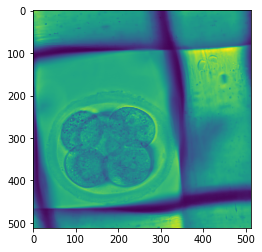

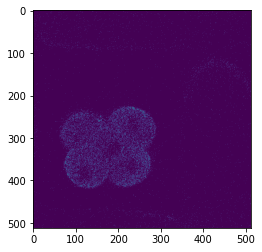

In [20]:
BF_TRAIN_PATH = f'{DATA_PATH}/train/bf_data'
inp, re, _ = load(BF_TRAIN_PATH+'/embryo_3_0_0.png')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(tf.squeeze(inp/255.0))
plt.figure()
plt.imshow(tf.squeeze(re/255.0))

In [21]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [22]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

  return cropped_image[0], cropped_image[1]

In [23]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [24]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 1
  new_size = 286 * 2
  input_image, real_image = resize(input_image, real_image, new_size, new_size)

  # randomly cropping to 512 x 512 x 1
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

As you can see in the images below
that they are going through random jittering
Random jittering as described in the paper is to

1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally

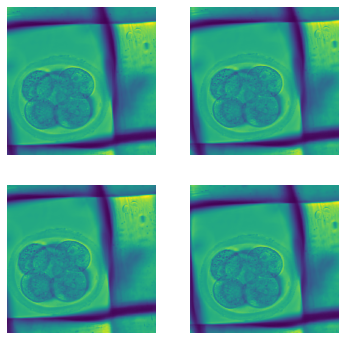

In [25]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(tf.squeeze(rj_inp/255.0))
  plt.axis('off')
plt.show()

In [26]:
def load_image_train(image_file):
  input_image, real_image, labels = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image, labels

In [27]:
def load_image_test(image_file):
  input_image, real_image, labels = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image, labels

## Input Pipeline

In [28]:
BF_TRAIN_PATH = f'{DATA_PATH}/train/bf_data'
train_dataset = tf.data.Dataset.list_files(BF_TRAIN_PATH+'/*.png')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [29]:
BF_TEST_PATH = f'{DATA_PATH}/test/bf_data'
test_dataset = tf.data.Dataset.list_files(BF_TEST_PATH+'/*.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [30]:
OUTPUT_CHANNELS = 1

In [31]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [32]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [33]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [34]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [35]:
def Generator():
  # inputs = tf.keras.layers.Input(shape=[256,256,1])

  # down_stack = [
  #   downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
  #   downsample(128, 4), # (bs, 64, 64, 128)
  #   downsample(256, 4), # (bs, 32, 32, 256)
  #   downsample(512, 4), # (bs, 16, 16, 512)
  #   downsample(512, 4), # (bs, 8, 8, 512)
  #   downsample(512, 4), # (bs, 4, 4, 512)
  #   downsample(512, 4), # (bs, 2, 2, 512)
  #   downsample(512, 4), # (bs, 1, 1, 512)
  # ]

  # up_stack = [
  #   upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
  #   upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
  #   upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
  #   upsample(512, 4), # (bs, 16, 16, 1024)
  #   upsample(256, 4), # (bs, 32, 32, 512)
  #   upsample(128, 4), # (bs, 64, 64, 256)
  #   upsample(64, 4), # (bs, 128, 128, 128)
  # ]


  inputs = tf.keras.layers.Input(shape=[512,512,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 256, 256, 64)
    downsample(128, 4), # (bs, 128, 128, 128)
    downsample(256, 4), # (bs, 64, 64, 256)
    downsample(512, 4), # (bs, 32, 32, 512)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(512, 4), # (bs, 32, 32, 1024)
    upsample(256, 4), # (bs, 64, 64, 512)
    upsample(128, 4), # (bs, 128, 128, 256)
    upsample(64, 4), # (bs, 256, 256, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

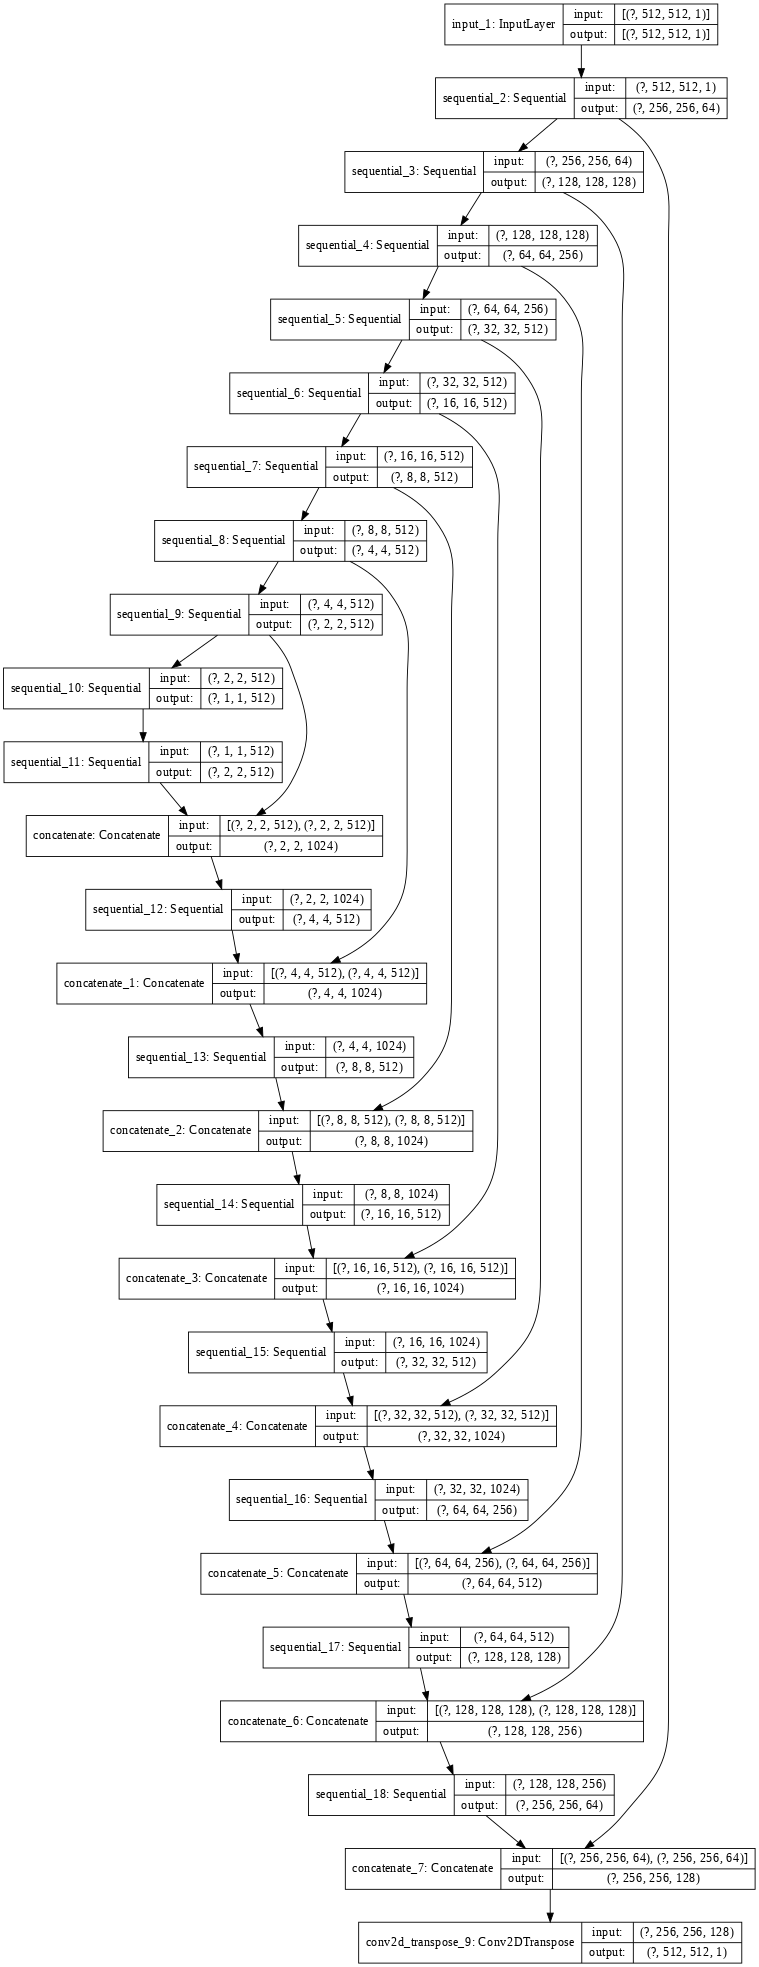

In [36]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

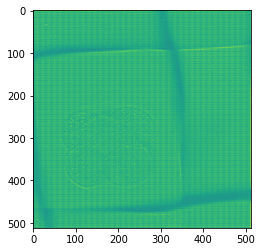

In [37]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(tf.squeeze(gen_output[0,...]))

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [38]:
LAMBDA = 100

In [39]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [40]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  # inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  # tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')
  inp = tf.keras.layers.Input(shape=[512, 512, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[512, 512, 1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  # down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  # down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  # down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  # zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  # conv = tf.keras.layers.Conv2D(512, 4, strides=1,
  #                               kernel_initializer=initializer,
  #                               use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  # batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  # leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  # zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  # last = tf.keras.layers.Conv2D(1, 4, strides=1,
  #                               kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  down1 = downsample(32, 4, False)(x) # (bs, 256, 256, 32)
  down2 = downsample(64, 4)(down1) # (bs, 128, 128, 64)
  down3 = downsample(128, 4)(down2) # (bs, 64, 64, 128)
  down4 = downsample(256, 4)(down3) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

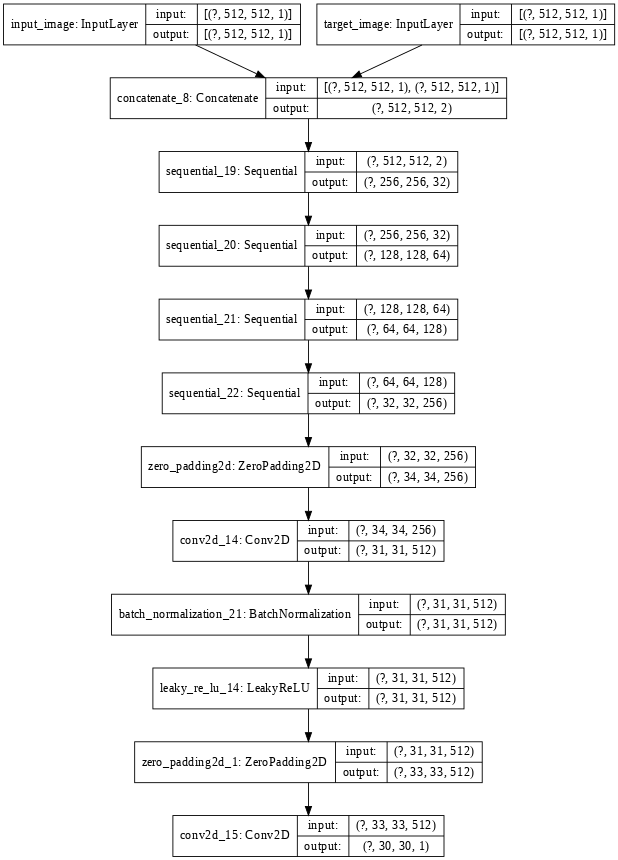

In [41]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

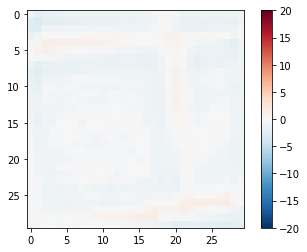

In [42]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [43]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [44]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [45]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [46]:
checkpoint_dir = CHECKPOINT_PATH
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate Images

Write a function to plot some images during training.

* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
we want the batch statistics while running the model
on the test dataset. If we use training=False, we will get
the accumulated statistics learned from the training dataset
(which we don't want)

In [47]:
def generate_labels(file_name):
  # ordered output: idx, timestep, pol
  file_name = str(file_name.numpy()[0])
  file_name = file_name.split('/')[-1]
  file_name = file_name.strip(".png'")
  labels = file_name.split('_')[1:]
  return [int(l) for l in labels]

def generate_images(model, test_input, tar, file_name, train_test, epoch):
  '''
  train_test is 'train' or 'test' or 'classify'
  '''

  idx, t, pol = generate_labels(file_name)

  prediction = model(test_input, training=True) 

  if train_test == 'classify':
    prediction = (prediction * 0.5 + 0.5).numpy()
    plt.imsave(f'{TRIAL_PATH}/{train_test}/{pol}/embryo{idx}_t{t}_pol{pol}.png', np.squeeze(prediction))
    return

  # turn off interactive plotting
  # https://stackoverflow.com/questions/15713279/calling-pylab-savefig-without-display-in-ipython
  # https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/
  plt.ioff()
  fig = plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = [f'Input Image (idx {idx}, t-step {t}, pol {pol})', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(np.squeeze(display_list[i] * 0.5 + 0.5))
    plt.axis('off')
  # plt.show()

  # put epoch num first so you can order by epoch more easily
  plt.savefig(f'{TRIAL_PATH}/{train_test}/epoch{epoch}_embryo{idx}_t{t}_pol{pol}.png', bbox_inches='tight')
  plt.close(fig)

In [48]:
for example_input, example_target, example_name in test_dataset.take(1):
  generate_images(generator, example_input, example_target, example_name, 'train', 0)

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [49]:
EPOCHS = 150
# EPOCHS = 5

In [50]:
summary_writer = tf.summary.create_file_writer(LOG_SUB_DIR)
os.listdir(LOG_SUB_DIR)

['events.out.tfevents.1606944846.c7456b1bc5b5.55.4781.v2']

In [51]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

The actual training loop:

* Iterates over the number of epochs.
* On each epoch it clears the display, and runs `generate_images` to show it's progress.
* On each epoch it iterates over the training dataset, printing a '.' for each example.
* It saves a checkpoint every 20 epochs.

In [52]:
MAX_EPOCH = 0

def fit(train_ds, epochs, test_ds):
  global MAX_EPOCH
  for epoch in range(epochs):
    MAX_EPOCH = epoch
    start = time.time()

    for example_input, example_target, example_name in test_ds.take(5):
      generate_images(generator, example_input, example_target, example_name, 'train', epoch)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target, name) in train_ds.enumerate():
      train_step(input_image, target, epoch)

    # saving (checkpoint) the model every 10 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint_prefix = os.path.join(checkpoint_dir, f"ckpt") #  f"ckpt{epoch}"
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

This training loop saves logs you can easily view in TensorBoard to monitor the training progress. Working locally you would launch a separate tensorboard process. In a notebook, if you want to monitor with TensorBoard it's easiest to launch the viewer before starting the training.

To launch the viewer paste the following into a code-cell:

In [53]:
# #docs_infra: no_execute
# %load_ext tensorboard
# %tensorboard --logdir='{LOG_DIR}'

Now run the training loop:

In [ ]:
fit(train_dataset, EPOCHS, test_dataset)

Epoch:  0
Time taken for epoch 1 is 314.9376564025879 sec
Epoch:  1
Time taken for epoch 2 is 287.819180727005 sec
Epoch:  2


If you want to share the TensorBoard results _publicly_ you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir  {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

Interpreting the logs from a GAN is more subtle than a simple classification or regression model. Things to look for::

* Check that neither model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
* The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2: That the discriminator is on average equally uncertain about the two options.
* For the `disc_loss` a value below `0.69` means the discriminator is doing better than random, on the combined set of real+generated images.
* For the `gen_gan_loss` a value below `0.69` means the generator i doing better than random at foolding the descriminator.
* As training progresses the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test

In [ ]:
!ls '{checkpoint_dir}'

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate using test dataset

In [ ]:
# Run the trained model on a few examples from the test dataset
for inp, tar, name in test_dataset.take(30):
  generate_images(generator, inp, tar, name, 'test', MAX_EPOCH)

In [ ]:
# Run the trained model on all examples from the test dataset
for inp, tar, name in test_dataset.take(len(test_dataset)):
  generate_images(generator, inp, tar, name, 'classify', MAX_EPOCH)

## Visualize the learning curves

In [ ]:
#docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir='{LOG_DIR}'